In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
#!pip uninstall nltk -y

In [4]:
#!pip install nltk -U

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Add "eagerEval.enabled" to beautify the way Spark DF is displayed

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
tweet_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified')

23/03/10 21:57:03 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Taking a random sample of 0.001% to avoid the kernel from dying

In [6]:
tweet_df = tweet_df.sample(withReplacement=False, fraction=0.001, seed=5555)

### Step 1.  Clean the data, remove stopwords and create index

#### Extracting text from the tweet text

In [7]:
text_df = tweet_df.select('tweet_text').withColumnRenamed("tweet_text",'text')
text = text_df.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

tokens_text = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [8]:
row_text = Row('text')
df_text = text.map(row_text).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{westerly yawanag...,129
{congratulations ...,130
{joy address hund...,131
{1981 patrick ewi...,132
{florida high sch...,133


In [9]:
df_text.count()

12862

In [10]:
df_tokens_text = spark.createDataFrame(tokens_text, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())
df_tokens_text.limit(5).toPandas()

,list_of_words,id
0,"[wife, paid, degrees, wife, paid, degrees, wife, paid, sons, college, degree, wife, kids, college, degree, know, good, want, live, educated, society]",0
1,"[scriblefy, grew, christian, asked, sunday, school, teacher, question, dinosaurs, bible, answer, ever, since, believe]",1
2,"[still, believes, admissions, training, must, visit, learn, touch, enlighten, thoughts, hiring, careermode, future, today, college, work, change, hope, careerschools, careercoach]",2
3,"[since, 2014, weve, seven, education, secretaries, gove, morgan, greening, hinds, williamson, zahawi, donelan, school, seven, headteachers, time, alarm, bells, would, ringing, loudly]",3
4,"[parent, dressed, easter, bunny, hands, something, inappropriate, texas, elementary, school, friday, austin, independent, school, district, said, would, updating, safety, protocols, incident]",4


### Step 2. Fit countvectorizer to create word features

In [11]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)

In [12]:
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)
df_vectorize_text.limit(5).toPandas()

,list_of_words,id,features
0,"[wife, paid, degrees, wife, paid, degrees, wife, paid, sons, college, degree, wife, kids, college, degree, know, good, want, live, educated, society]",0,"(0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[scriblefy, grew, christian, asked, sunday, school, teacher, question, dinosaurs, bible, answer, ever, since, believe]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[still, believes, admissions, training, must, visit, learn, touch, enlighten, thoughts, hiring, careermode, future, today, college, work, change, hope, careerschools, careercoach]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[since, 2014, weve, seven, education, secretaries, gove, morgan, greening, hinds, williamson, zahawi, donelan, school, seven, headteachers, time, alarm, bells, would, ringing, loudly]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[parent, dressed, easter, bunny, hands, something, inappropriate, texas, elementary, school, friday, austin, independent, school, district, said, would, updating, safety, protocols, incident]",4,"(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table

**Note:** Adding more hash tables will increase the accuracy at the expense of training time

In [13]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)

In [14]:
model_text = mh.fit(df_vectorize_text)
df_hashed_b = mh.fit(df_vectorize_text).transform(df_vectorize_text).cache()

In [15]:
df_hashed_text = df_text.join(df_hashed_b, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
222,{college football...,"[college, footbal...","(31361,[2,69,91,1...","[[3.00249524E8], ..."
270,{pandemic driven ...,"[pandemic, driven...","(31361,[0,8,9,613...","[[4.7945584E7], [..."
293,{mercedesamgf1 de...,"[mercedesamgf1, d...","(31361,[1,3,6,110...","[[2.53318475E8], ..."
730,{launch pm shri p...,"[launch, shri, pr...","(31361,[5,10,92,1...","[[515903.0], [7.3..."
938,{rutgers universi...,"[rutgers, univers...","(31361,[1,120,416...","[[6.9147607E7], [..."


### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** we are joining dataframe to itself to get near-duplicate pairs

#### Low jaccard distance

In [16]:
jaccard_distance = 0.3

df_dups_text = model_text.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [17]:
df_dups_30_text = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,3069,3583,"(love rich black people spoil black kids idc 10 year old got cuban white people throw 16 year old sons 80 thousand dollar bar mitzvah party swear black children deserve college fund nothing less,)","(love rich black people spoil black kids idc 10 year old got cuban white people throw 16 year old sons 80 thousand dollar bar mitzvah party swear black children deserve college fund nothing less,)"
1,0.0,6700,6815,"(kids first day school today school starts tell kids ruby bridges first black child white public elementary school south ms bridges 67 67,)","(kids first day school today school starts tell kids ruby bridges first black child white public elementary school south ms bridges 67 67,)"
2,0.0,5693,8036,"(2006 high school english teacher asked students write famous author amp ask advice amp kurt vonnegut one respond amp response doozy,)","(2006 high school english teacher asked students write famous author amp ask advice amp kurt vonnegut one respond amp response doozy,)"
3,0.0,1687,11286,"(male university students walked exam protest taliban decision ban female students university education several male professors also resigned far must happen across country,)","(male university students walked exam protest taliban decision ban female students university education several male professors also resigned far must happen across country,)"
4,0.0,9218,11903,"(college really makes wonder parents teach shit proper etiquette cleanliness manners common courtesy like anything,)","(college really makes wonder parents teach shit proper etiquette cleanliness manners common courtesy like anything,)"


In [19]:
records = df_hashed_text.count()
dups_text_30 = df_dups_text.select('id_A').count()
uniques = records - dups_text_30

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_text_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  12862
Duplicate titles based on { 0.3 } jaccard distance:  5969
Unique titles based on { 0.3 } jaccard distance:  0.3 :  6893


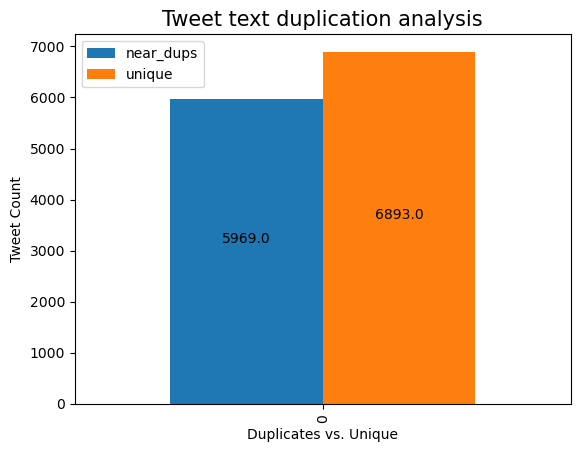

In [25]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_text_30], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet text duplication analysis', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
ax.set_ylabel("Tweet Count")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Medium jaccard distance

In [26]:
jaccard_distance = 0.5

df_dups_text = model_text.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [27]:
df_dups_50_text = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,6917,11607,"(average weekly wages 1973 873 2022 813 median home 1973 30 200 2022 433 100 monthly rent 1973 108 2022 2 002 tuition fees university california 1973 150 2022 13 104 boomer cant slackers pay college amp pay loans like,)","(average weekly wages 1973 873 2022 813 median home 1973 30 200 2022 433 100 monthly rent 1973 108 2022 2 002 tuition fees university california 1973 150 2022 13 104 boomer cant slackers pay college amp pay loans like,)"
1,0.117647,287,6398,"(2006 high school english teacher asked students write famous author amp ask advice kurt vonnegut one respond reply doozy,)","(2006 high school english teacher asked students write famous author amp ask advice amp kurt vonnegut one respond amp response doozy,)"
2,0.000000,1016,2136,"(teacher mocked front class school saying lets meet succeed life loser sending regards lm writing masters thesis serving ceo un representative ingos helped millions around world still wanna meet,)","(teacher mocked front class school saying lets meet succeed life loser sending regards lm writing masters thesis serving ceo un representative ingos helped millions around world still wanna meet,)"
3,0.000000,9657,10641,"(keenan anderson 31 year old high school teacher amp father stopped la police help accident instead cuffed pinned amp tased repeatedly begged stop keenan died cardiac arrest excessive tasing crime asking police help,)","(keenan anderson 31 year old high school teacher amp father stopped la police help accident instead cuffed pinned amp tased repeatedly begged stop keenan died cardiac arrest excessive tasing crime asking police help,)"
4,0.000000,1246,2464,"(potentially unpopular opinion teach whole curriculum without homework curriculum problem kids quiet quitting expecting work school 7 8 hrs work expect protect peace amp find joy leave,)","(potentially unpopular opinion teach whole curriculum without homework curriculum problem kids quiet quitting expecting work school 7 8 hrs work expect protect peace amp find joy leave,)"


In [28]:
records = df_hashed_text.count()
dups_text_50 = df_dups_text.select('id_A').count()
uniques = records - dups_text_50

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_text_50)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  12862
Duplicate titles based on { 0.5 } jaccard distance:  6575
Unique titles based on { 0.5 } jaccard distance:  0.5 :  6287


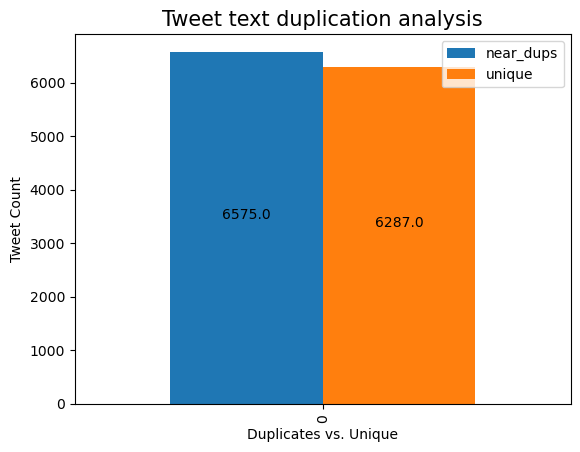

In [29]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_text_50], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet text duplication analysis', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
ax.set_ylabel("Tweet Count")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### High jaccard distance

In [30]:
jaccard_distance = 0.7

df_dups_text = model_text.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [31]:
df_dups_70_text = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,3449,9635,"(overheard university student say arctic monkeys dad favourite band little passage time relentless unfathomable cruel unforgiving,)","(overheard university student say arctic monkeys dad favourite band little passage time relentless unfathomable cruel unforgiving,)"
1,0.666667,1475,5317,"(boomshakamaui one high school smart one college smart goldblum professor smart,)","(high school college uni lovers lovers zeenunew,)"
2,0.687500,3571,6796,"(live akron high school vs byers high school varsity boys baseball watch saturday may 21 2022 2 00 pm,)","(oblong high school vs dupo high school varsity football 2022 live date 26 aug 22 time 8 00 pm,)"
3,0.000000,7508,11879,"(school audacity ban prime leaving students dehydrated counter blatant wrongdoing sending truckload prime school many schools retweet tweet represent school get prime,)","(school audacity ban prime leaving students dehydrated counter blatant wrongdoing sending truckload prime school many schools retweet tweet represent school get prime,)"
4,0.000000,4700,4789,"(school meals free everybody charging children eat somewhere legally required entire day exploitative,)","(school meals free everybody charging children eat somewhere legally required entire day exploitative,)"


In [32]:
records = df_hashed_text.count()
dups_text_70 = df_dups_text.select('id_A').count()
uniques = records - dups_text_70

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_text_70)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  12862
Duplicate titles based on { 0.7 } jaccard distance:  9997
Unique titles based on { 0.7 } jaccard distance:  0.7 :  2865


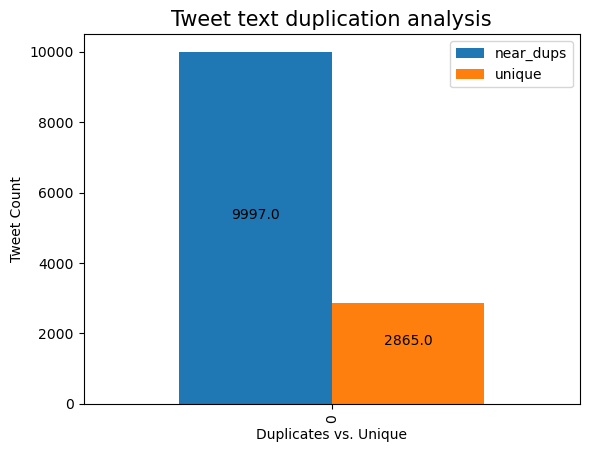

In [33]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_text_70], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweet text duplication analysis', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
ax.set_ylabel("Tweet Count")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Step 5. Compare thresholds side-by-side

#### Select all pairs of duplicate titles across jaccard similarities

In [34]:
df_dups_30_text_id = df_dups_30_text.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_text_id = df_dups_50_text.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_text_id = df_dups_70_text.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_text_id.count())
print(df_dups_50_text_id.count())
print(df_dups_70_text_id.count())

5969


6575


9997


In [35]:
dups_combined_text = df_dups_70_text_id.join(df_dups_50_text_id, on=((df_dups_70_text_id.id_70_A == df_dups_50_text_id.id_50_A) & (df_dups_70_text_id.id_70_B == df_dups_50_text_id.id_50_B)), how="left_outer")\
.join(df_dups_30_text_id, on=((df_dups_70_text_id.id_70_A == df_dups_30_text_id.id_30_A) & (df_dups_70_text_id.id_70_B == df_dups_30_text_id.id_30_B)), how="left_outer")

dups_combined_text.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
{baovesinhvienhuf...,{baovesinhvienhuf...,4108,8151,4108,8151,4108,8151
{1 dam breaking j...,{breaking end nea...,588,6123,588,6123,null,null
{told primary sch...,{told primary sch...,2184,5413,2184,5413,2184,5413
{russian occupant...,{russian occupant...,8037,11288,8037,11288,8037,11288
{miss ms pain pro...,{school teacher},3327,12480,null,null,null,null


#### Create a Duplicate vs Non-Dup flag for each jaccard similarity

In [ ]:
dups_combined_text = dups_combined_text.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined_text.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
{modijiextendneet...,{modijiextendneet...,Duplicate,Duplicate,Duplicate
{question califor...,{100 california m...,Duplicate,Duplicate,Duplicate
{tatami galaxy 20...,{tatami galaxy 20...,Duplicate,Duplicate,Duplicate
{asuu ahmed musa ...,{ahmed musa asked...,Non-Dup,Non-Dup,Duplicate
{live central hig...,{charles e jordan...,Non-Dup,Non-Dup,Duplicate


#### Select a sample of records across 3 thresholds (jaccard similarities):

In [38]:
dups_combined_text_sample = \
dups_combined_text.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined_text.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined_text.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [43]:
pd.set_option('display.max_rows', 30)
dups_combined_text_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(13 years entering nba stephen curry college grad stephen completed final semester coursework spring receive bachelor arts degree major sociology davidson college congrats class 2022,)","(13 years entering nba stephen curry college grad stephen completed final semester coursework spring receive bachelor arts degree major sociology davidson college congrats class 2022,)",Duplicate,Duplicate,Duplicate
1,"(1 florida english teacher vicki baggett seeking remove 150 books school libraries says responsibility protect minors inappropriate content former amp current students say baggett openly promotes racist amp homophobic beliefs class,)","(1 florida english teacher vicki baggett seeking remove 150 books school libraries says responsibility protect minors inappropriate content former amp current students say baggett openly promotes racist amp homophobic beliefs class,)",Duplicate,Duplicate,Duplicate
2,"(one friends primary school teacher muslim kid told teacher 2 mummies school got excited starting telling everyone brave accept lgbt stuff muslim etc anyway turns dad 2 wives,)","(one friends primary school teacher muslim kid told teacher 2 mummies school got excited starting telling everyone brave accept lgbt stuff muslim etc anyway turns dad 2 wives,)",Duplicate,Duplicate,Duplicate
3,"(giveway 20 wl 5 nft funnyybuns want educate masses carrot school building cutest community 1 follow funnyybuns amp suiglobal 2 retweet 3 tag friends 72h suinami sui suiglobal suiecosystem giveaways,)","(giveway 20 wl 5 nft funnyybuns want educate masses carrot school building cutest community 1 follow funnyybuns amp suiglobal 2 retweet 3 tag friends 72h suinami sui suiglobal suiecosystem giveaways,)",Duplicate,Duplicate,Duplicate
4,"(every single day makes realize fucking pandemic robbed college students college life truly deserve,)","(every single day makes realize fucking pandemic robbed college students college life truly deserve,)",Duplicate,Duplicate,Duplicate
5,"(black money recovered today house tmc ministers aide ed says proceeds primary education recruitment scam merely tip iceberg bengal primary school teacher gets rs 22 000 per month eleven notes,)","(black money recovered today house tmc ministers aide ed says proceeds primary education recruitment scam merely tip iceberg bengal primary school teacher gets rs 22 000 per month eleven notes,)",Duplicate,Duplicate,Duplicate
6,"(4 25 suspension education puts among top five countries children school despite rapid progress since 1990s low starting point stoptigraygenocide stopwarontigray undppa un,)","(suspension education puts among top five countries children school despite rapid progress since 1990s low starting point stoptigraygenocide stopwarontigray undppa un lieliti,)",Duplicate,Duplicate,Duplicate
7,"(dearest ibu please ask change building 30 school 6 new classroom many school building bad condition free thousand one year electricity bill use money something else,)","(dearest ibu please ask change building 30 school 6 new classroom many school building bad condition free thousand one year electricity bill use money something else,)",Duplicate,Duplicate,Duplicate
8,"(cant teach florida schools may make uncomfortable governor white power trump afterbirth ron may fire teacher teaches teach children home floriduh,)","(cant teach florida schools may make uncomfortable governor white power trump afterbirth ron may fire teacher teaches teach children home floriduh,)",Duplicate,Duplicate,Duplicate
9,"(sehun high school student role 1 x0 anniversary fanmeet 1 x0withexols exolscelebratewithexo,)","(sehun high school student role 1 x0 anniversary fanmeet 1 x0withexols exolscelebratewithexo,)",Duplicate,Duplicate,Duplicate
